#### The objective of our k-mean clustering analysis is trying to understand how cyclists perform on flat surface, inclined surface or a combination of both. 

## **Initialization**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.ensemble import RandomForestClassifier

### Importing libraries

In [2]:
cyclists_df = pd.read_csv('./dataset/cyclists_cleaned.csv')

copy = cyclists_df.copy()

### **Utility function** definition

In [3]:
def k_means_calculation(df):

    sse = list()
    davies = list()
    silhouette = list()
    max_k = 15

    for k in range(2, max_k + 1):
        kmeans_pass = KMeans(n_clusters=k, n_init=10, max_iter=100)
        kmeans_pass.fit(df)
        sse_pass = kmeans_pass.inertia_
        sse.append(sse_pass)
        davies.append(davies_bouldin_score(df, kmeans_pass.labels_))
        silhouette.append(silhouette_score(df, kmeans_pass.labels_))
   
    plt.figure(figsize=(6, 3))
    plt.plot(range(2, len(sse) + 2), sse, marker='o')
    plt.ylabel('SSE')
    plt.xlabel('K')
    plt.title('SSE')
    plt.show()
    
    plt.figure(figsize=(6, 3))
    plt.plot(range(2, len(silhouette) + 2), silhouette, marker='o')
    plt.ylabel('SILHOUETTE')
    plt.xlabel('K')
    plt.title('SILHOUETTE')
    plt.show()

    plt.figure(figsize=(6, 3))
    plt.plot(range(2, len(davies) + 2), davies, marker='o')
    plt.ylabel('DAVIES')
    plt.xlabel('K')
    plt.title('DAVIES')
    plt.show()

### Feature Selection and Normalization

We believe the selected feature will help us understand how each cyclist perform on different types of road.<br>
We do not wish to rank cyclists, but the kind of race each cyclist is more agile<br><br>

We use min-max scaler because most of the selected feature have a highly skewed distribution

In [4]:
# Select features for clustering
features = ['bmi', 'weight', 'average_climb_length', 'average_intensity', 'average_race_length']
feature_data = copy[features]
scaler = MinMaxScaler()
scaled = scaler.fit_transform(feature_data)

# Convert back to a DataFrame for clarity
scaled = pd.DataFrame(scaled, columns=features)

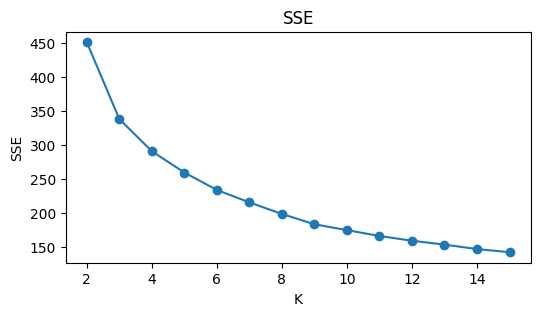

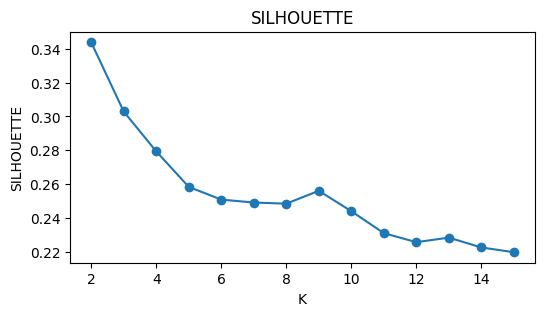

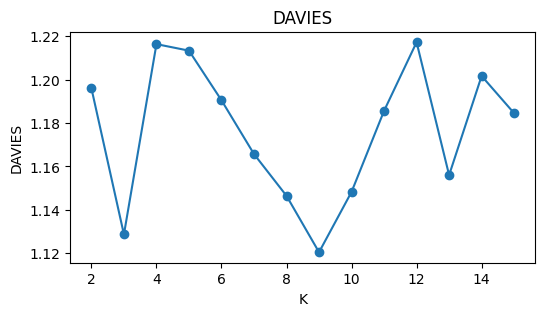

In [5]:
k_means_calculation(scaled)

### Run K-mean Analysis

The decision of optimal k is given by the 3 indicators, so that the choice of k:
- in SSE should indicate the point where curves the function
- in Silhouette should have the highest possible value
- in Davis-Bouldin should have the lowest possible value

cluster occurrences: [2041, 1651, 1943]


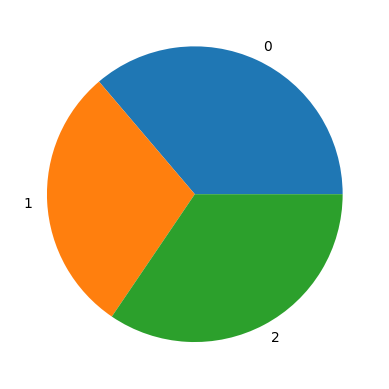

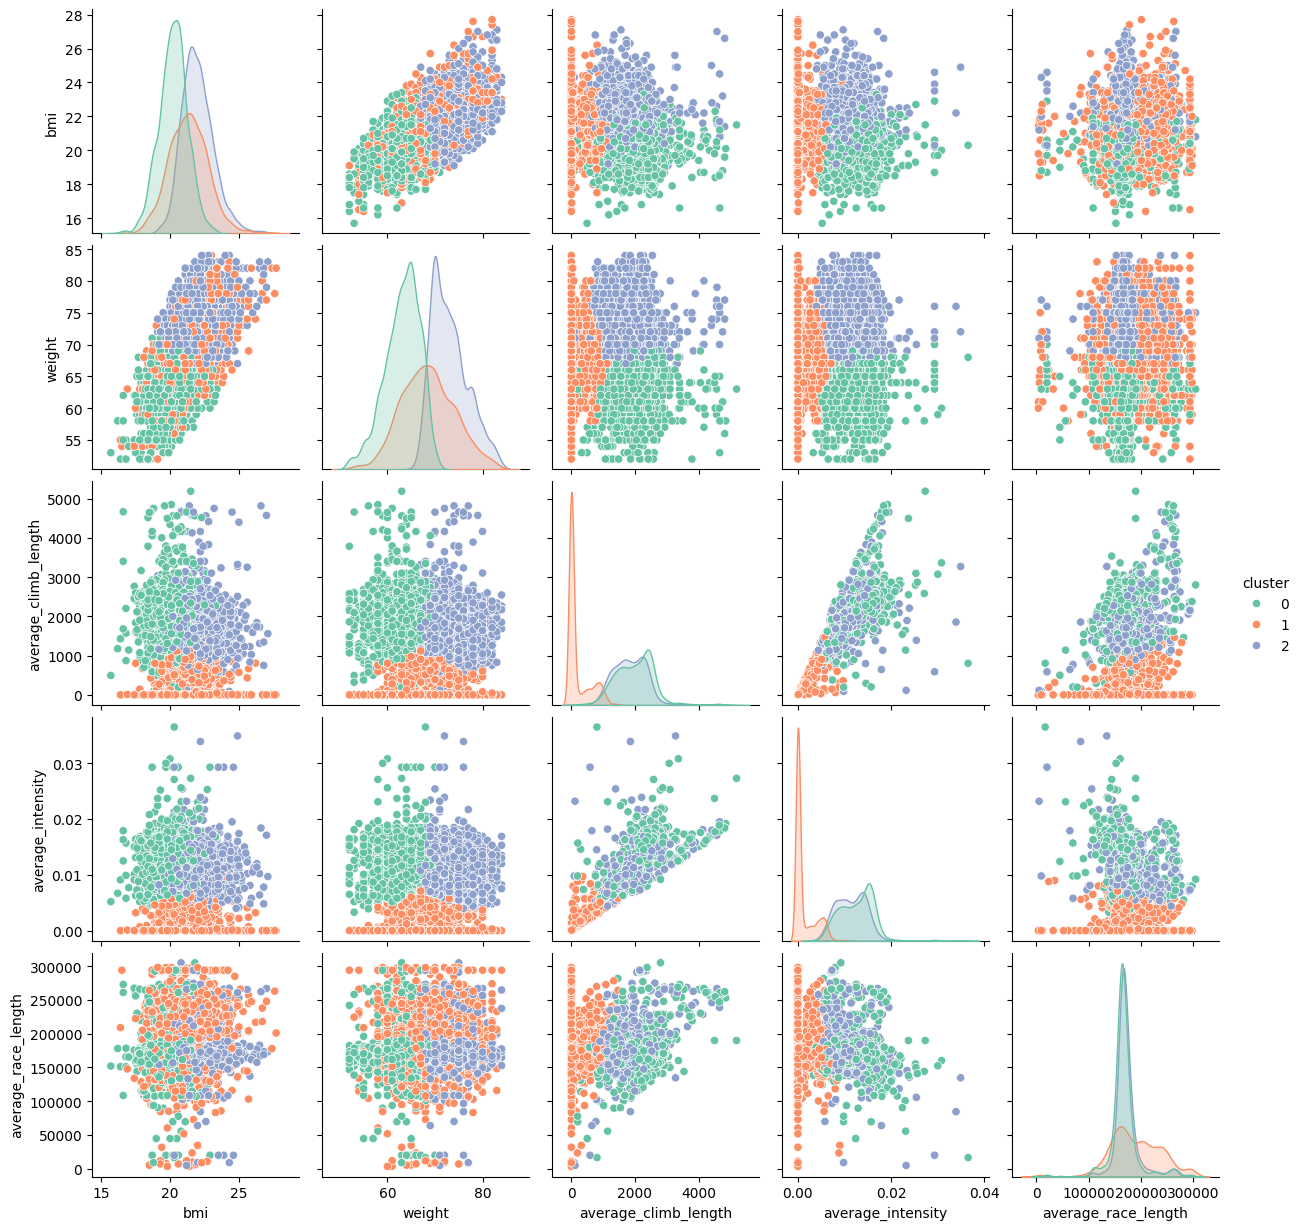

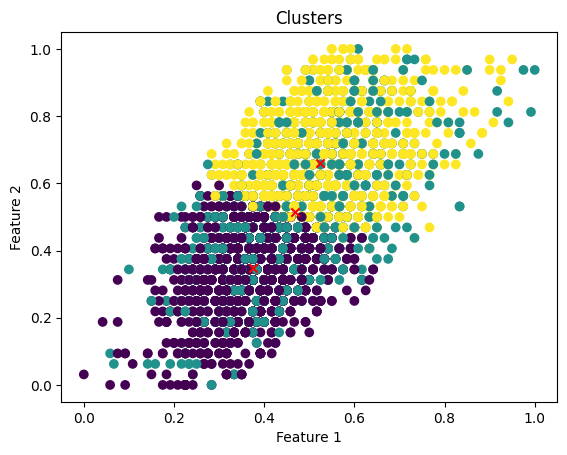

In [17]:
optimal_k = 3
kmeans = KMeans(n_clusters = optimal_k, random_state = 42)
kmeans.fit(scaled)

# Get cluster labels and cluster centers
labels = kmeans.labels_
centers = kmeans.cluster_centers_

# Add labels to the original data for interpretation
copy["cluster"] = labels
n_clusters = len(np.unique(kmeans.labels_))
occ_list = []
for k in range(n_clusters):
    occ_list.append(np.count_nonzero(kmeans.labels_ == k))
print('cluster occurrences:', occ_list)

# Visualize the clusters through a pie chart
label = range(n_clusters)
plt.pie(occ_list, labels=label, colors=sns.color_palette(n_colors=n_clusters))
plt.show()

# Add the cluster labels to the cluster_data for visualization
cluster_data_with_labels = feature_data.copy()
cluster_data_with_labels["cluster"] = labels

sns.pairplot(copy, hue='cluster', vars=features, palette='Set2')
plt.show()

# Visualize the clusters 
plt.scatter(scaled.values[:, 0], scaled.values[:, 1], c=labels)
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x')  # Cluster centers
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Clusters")
plt.show()

### Summary of the parameters used in the analysis

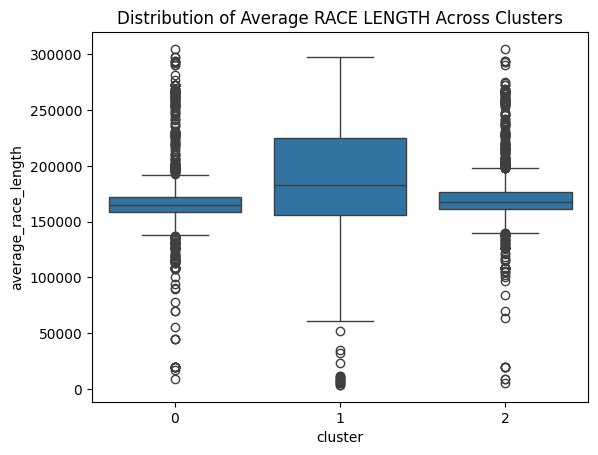

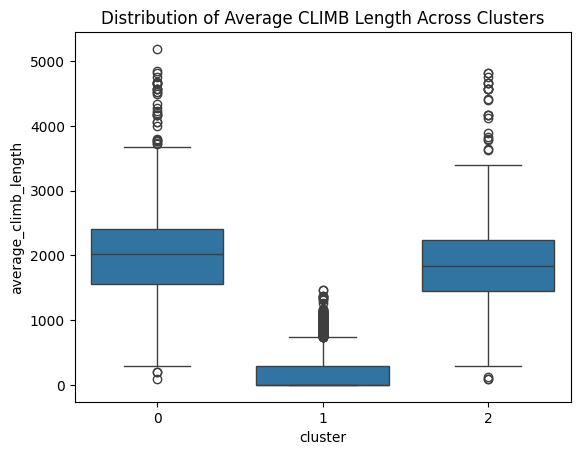

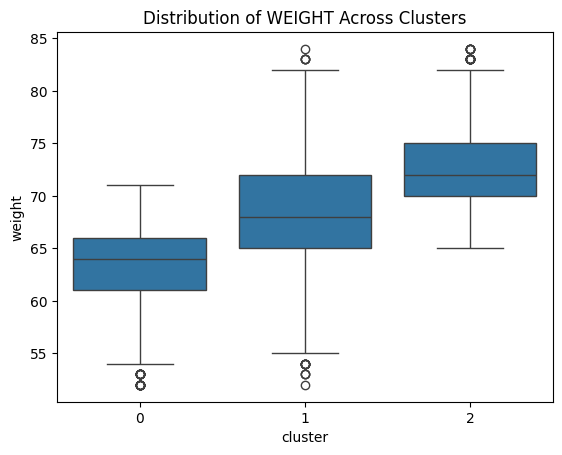

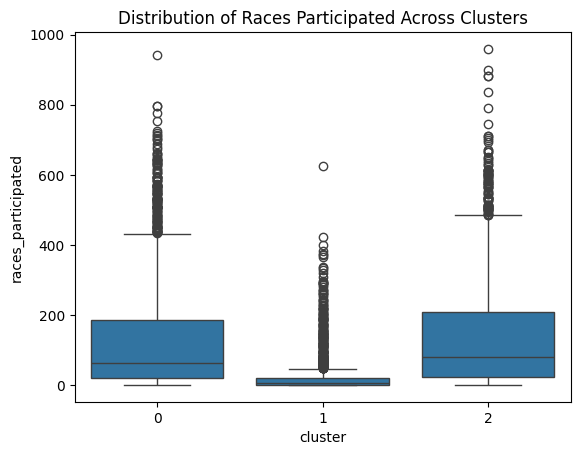

In [18]:
sns.boxplot(x='cluster', y='average_race_length', data=copy)
plt.title('Distribution of Average RACE LENGTH Across Clusters')
plt.show()

sns.boxplot(x='cluster', y='average_climb_length', data=copy)
plt.title('Distribution of Average CLIMB Length Across Clusters')
plt.show()

sns.boxplot(x='cluster', y='weight', data=copy)
plt.title('Distribution of WEIGHT Across Clusters')
plt.show()

sns.boxplot(x='cluster', y='races_participated', data=copy)
plt.title('Distribution of Races Participated Across Clusters')
plt.show()

### Feature importance evaluation through the use of Random Forest

                Feature  Importance
1                weight    0.379421
3     average_intensity    0.271793
2  average_climb_length    0.220011
0                   bmi    0.106853
4   average_race_length    0.021922


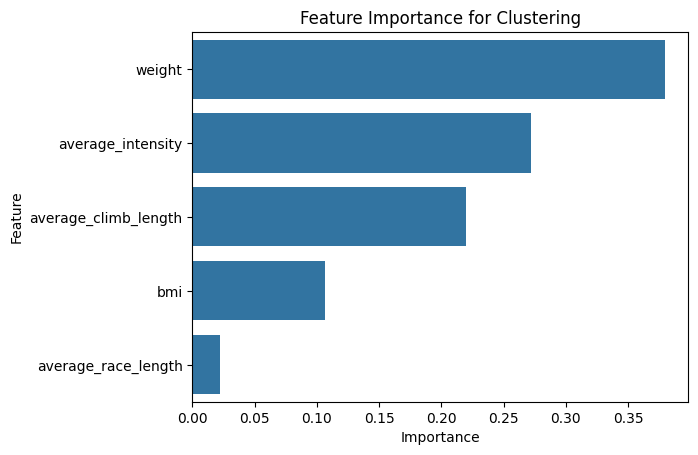

In [19]:
X = scaled[features]
y = copy['cluster']

# Train Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Feature Importance
importances = pd.DataFrame({'Feature': features, 'Importance': rf.feature_importances_})
importances.sort_values(by='Importance', ascending=False, inplace=True)
print(importances)

# Plot Feature Importance
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Feature Importance for Clustering')
plt.show()

### Silhouette score

In [20]:
silhouette_avg = silhouette_score(scaled, copy['cluster'])
print(f"Silhouette Score: {silhouette_avg:.2f}")

Silhouette Score: 0.30


### Final visual presentation of analysis

        bmi    weight  average_climb_length  average_intensity  \
0  0.375403  0.347492              0.385309           0.345492   
1  0.468344  0.515672              0.037711           0.033330   
2  0.524875  0.659182              0.356266           0.312919   

   average_race_length  
0             0.542273  
1             0.617020  
2             0.557735  


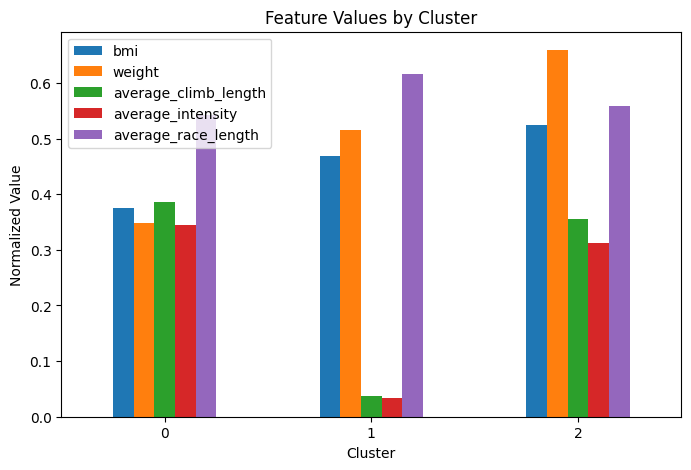

In [21]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=features)
print(centroids)

# Plot centroids
centroids.plot(kind='bar', figsize=(8, 5))
plt.title('Feature Values by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Normalized Value')
plt.xticks(rotation=0)
plt.show()

### **Observation**
We first ignore the 'average_race_length' feature for it is not important in out analysis and also it shows the similar range of values on all clusters<br>
We can oberse that:
- cluster 0 has *low* bmi & weight but *high* on inclined surface indicators
- cluster 1 has *high* bmi & weight but *low* on inclined surface indicators
- cluster 2 has *high* bmi & weight and also *high* on inclined surface indicators
<br><br>

### **Conclusion**
1. we observe that cyclists with lower weight have a higher participation on inclined surface race. Thanks to their light weightness, they have an advantage in such race
2. cluster 1 are cyclists that are not used to compete on inclined surface
3. cluster 2 are cyclists that can 'feel ease' on both inclined and flat surface

### Future work
Understand which cluster has better performance on inclined surface